In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Hyperparamètres
input_dim = 28 * 28  # Taille des images aplaties
hidden_dim = 128
output_dim = 10 
batch_size = 32
learning_rate = 0.001
num_epochs = 10

# Prétraitement des données
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir en tenseur
    transforms.Normalize((0.5,), (0.5,))  # Normalisation
])

# Charger les données MNIST
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# Définir le modèle MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, output_dim),
            nn.LogSoftmax(dim=1)  # Pour la classification multi-classes
        )

    def forward(self, x):
        return self.model(x)

In [10]:
model = MLP(input_dim, hidden_dim, output_dim)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        # Aplatir les images
        images = images.view(images.size(0), -1)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass et mise à jour des poids
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), -1)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Epoch [1/10], Loss: 0.4623
Epoch [2/10], Loss: 0.2694
Epoch [3/10], Loss: 0.2298
Epoch [4/10], Loss: 0.2080
Epoch [5/10], Loss: 0.1950
Epoch [6/10], Loss: 0.1867
Epoch [7/10], Loss: 0.1793
Epoch [8/10], Loss: 0.1690
Epoch [9/10], Loss: 0.1651
Epoch [10/10], Loss: 0.1591
Test Accuracy: 96.45%


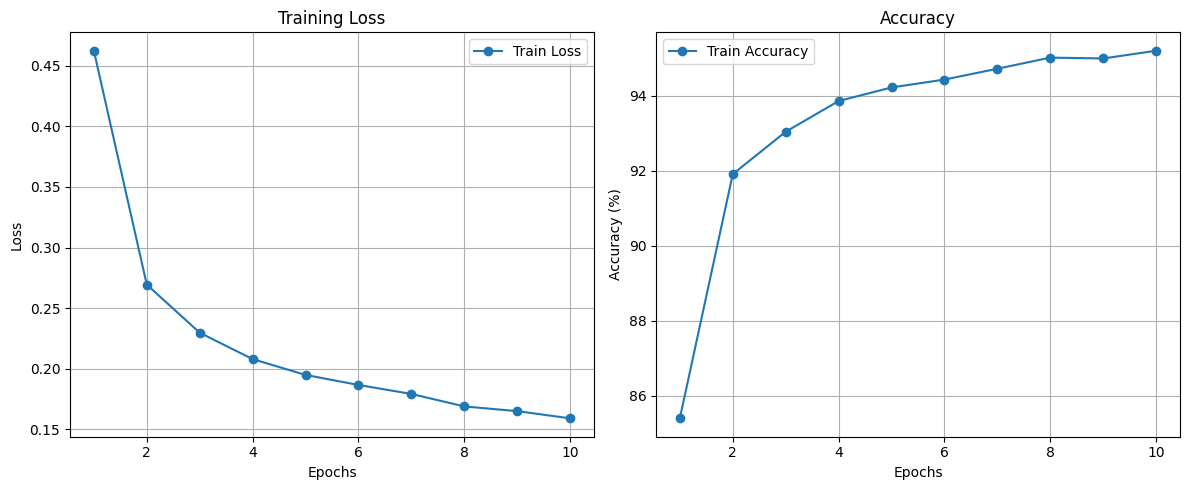

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Courbe de la perte
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid()

# Courbe de l'accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
# plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [14]:
from BayesianNeuralNetwork import BayesianNN

hidden_dim = 128
num_hidden_layers = 2
kl_weight = 1e-6

model = BayesianNN(input_size=input_dim, output_size=output_dim, num_hidden_layers=num_hidden_layers, layer_width=hidden_dim)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

bay_train_losses = []
bay_train_accuracies = []
bay_test_accuracies = []

# Entraînement
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.view(images.size(0), -1)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Ajouter la perte KL
        kl_loss = model.compute_total_kl_loss()
        total_loss = loss + kl_weight * kl_loss

        # Backward pass et mise à jour des poids
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    bay_train_losses.append(running_loss / len(train_loader))
    bay_train_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Évaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), -1)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

KeyboardInterrupt: 